In [224]:
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

### Acceso a los datos

In [14]:
# Accedo y descargo los archivos de precios del dolar en S3
s3_resource = boto3.resource('s3')
s3_client = boto3.client('s3')
bucket_name = 'proccesed-dollar-mia-electiva-3'

bucket = s3_resource.Bucket(bucket_name)

folder_name = 'precios_dolar'

for obj in bucket.objects.all():
    s3_client.download_file(bucket_name, obj.key, f'{folder_name}/{obj.key}')

In [32]:
# Lee todos los archivos para extraer el precio diario del dolar al cierre de la jornada
dollar_close_price_daily = []

for filename in os.listdir(folder_name):
    file_path = (os.path.join(folder_name, filename))
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, usecols=['fecha', 'valor'])
        dollar_close_price_daily.append(df.iloc[-1])

df_dollar_daily_price = pd.concat(dollar_close_price_daily, axis=1).transpose().reset_index(drop=True)

In [45]:
# Renombro columnas
df_dollar_daily_price = df_dollar_daily_price.rename(columns={'valor':'precio'})

### Explorar los datos

In [46]:
# Elimino duplicados
df_dollar_daily_price = df_dollar_daily_price.drop_duplicates()

In [47]:
df_dollar_daily_price.head()

,fecha,precio
0,2023-03-17 18:00:00,4824.1162
1,2023-03-03 18:00:00,4780.8829
2,2023-03-27 17:59:57,4686.8365
3,2023-03-06 17:59:55,4734.7354
4,2023-03-22 18:00:00,4776.2492


In [60]:
df_dollar_daily_price.dtypes

fecha     object
precio    object
dtype: object

In [106]:
# Cambiar los tipos
df_dollar_daily_price['fecha'] = pd.to_datetime(df_dollar_daily_price['fecha'])
df_dollar_daily_price['fecha'] = df_dollar_daily_price['fecha'].dt.floor('D')
df_dollar_daily_price['precio'] = df_dollar_daily_price['precio'].astype(float)

In [107]:
df_dollar_daily_price.dtypes

fecha     datetime64[ns]
precio           float64
dtype: object

In [132]:
# Ordeno por fechas
df_dollar_daily_price = df_dollar_daily_price.sort_values(by='fecha')
df_dollar_daily_price = df_dollar_daily_price.reset_index(drop=True)

In [133]:
df_dollar_daily_price.head()

,fecha,precio
0,2023-02-17,4920.7143
1,2023-02-20,4914.4387
2,2023-02-21,4950.1162
3,2023-02-22,4924.7666
4,2023-02-23,4853.9941


In [134]:
df_dollar_daily_price.describe()

,precio
count,31.000000
mean,4770.294703
std,104.671019
min,4570.765500
25%,4710.785950
50%,4776.249200
75%,4849.088000
max,4950.116200


<AxesSubplot: xlabel='fecha'>

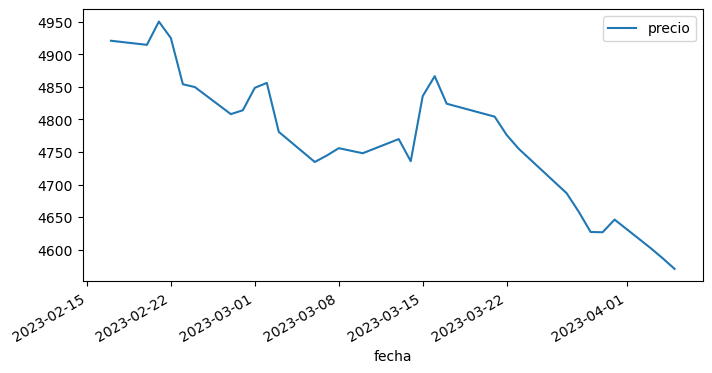

In [135]:
df_dollar_daily_price.plot(x='fecha', y=['precio'], figsize=(8,4))

#### Tendencia

<AxesSubplot: xlabel='fecha'>

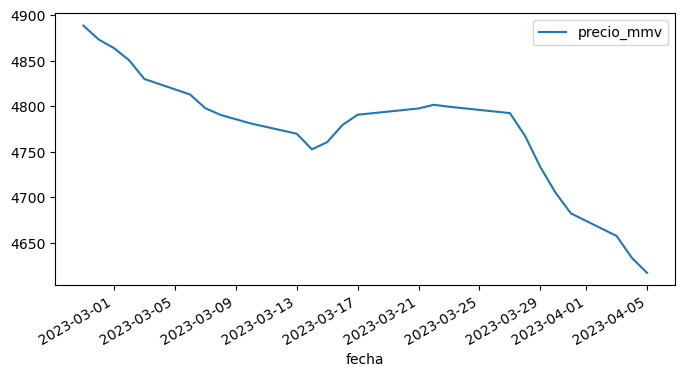

In [136]:
# Media movil
df_mmv = pd.DataFrame({'fecha':df_dollar_daily_price['fecha']})
df_mmv['precio_mmv'] = df_dollar_daily_price['precio'].rolling(window=7).mean()
df_mmv.plot(x='fecha', y=['precio_mmv'], figsize=(8,4))

#### Estacionalidad

In [187]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [138]:
df_test_adfuller = sm.tsa.stattools.adfuller(df_dollar_daily_price['precio'], autolag='AIC')
result = pd.Series(df_test_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                 -0.535585
p-value                         0.884883
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


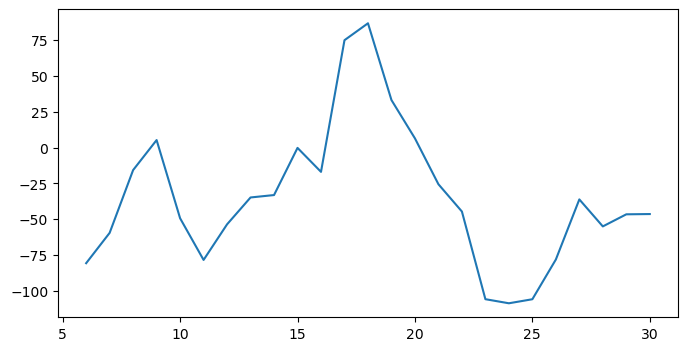

In [175]:
# Como la serie es no estacionaria, se intenta transformarla en estacionaria usando el metodo de resta de la media movil
mmv_diff = df_dollar_daily_price['precio']-df_mmv['precio_mmv']
plt.figure(figsize=(8,4))
plt.plot(mmv_diff, label='Diferencia entre precio y media movil')
plt.show()
mmv_diff.dropna(inplace=True)

In [165]:
df_mmv_adfuller = sm.tsa.stattools.adfuller(mmv_diff, autolag='AIC')
result = pd.Series(df_mmv_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_mmv_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  0.079945
p-value                         0.964665
#Lags Used                      9.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


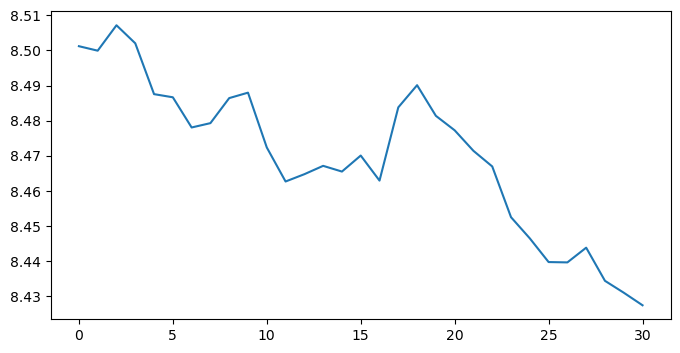

In [170]:
# Como la serie es no estacionaria, se intenta transformarla en estacionaria usando el metodo de resta de la media movil con transformacion logaritmica
precio_log = np.log(df_dollar_daily_price['precio'])
plt.figure(figsize=(8,4))
precio_log.plot(label='Precio con transformacion logaritmica')
plt.show()

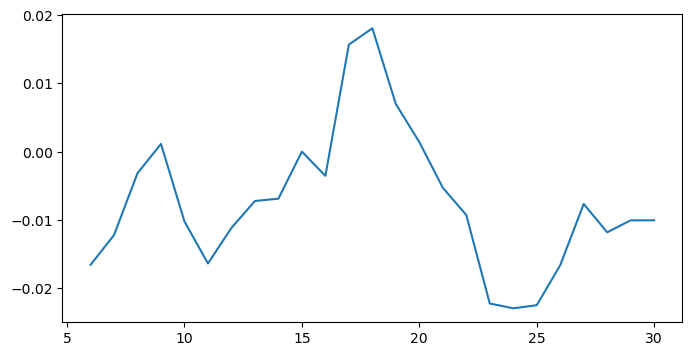

In [171]:
log_mmv = pd.Series.rolling(precio_log,window=7,center=False).mean()
log_mmv_diff = precio_log-log_mmv
plt.figure(figsize=(8,4))
plt.plot(log_mmv_diff, label='Diferencia entre precio y media movil')
plt.show()
log_mmv_diff.dropna(inplace=True)

In [172]:
df_log_adfuller = sm.tsa.stattools.adfuller(log_mmv_diff, autolag='AIC')
result = pd.Series(df_log_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_log_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  0.132343
p-value                         0.968201
#Lags Used                      9.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


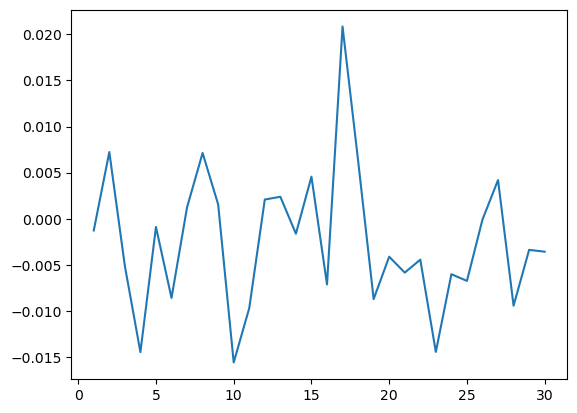

In [173]:
# Como la serie es no estacionaria, se intenta transformarla en estacionaria usando el metodo de diferencia de primer orden
precio_log_diff = precio_log - precio_log.shift()
precio_log_diff.dropna(inplace=True)
plt.plot(precio_log_diff)
plt.show()

In [174]:
df_log_diff_adfuller = sm.tsa.stattools.adfuller(precio_log_diff, autolag='AIC')
result = pd.Series(df_log_diff_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_log_diff_adfuller[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                 -4.725856
p-value                         0.000075
#Lags Used                      0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


#### Conclusión
El metodo de transformación por diferencia de primer orden dio el mejor resultado dando un resultado aceptable en el nivel de estacionalidad

### Time Lags

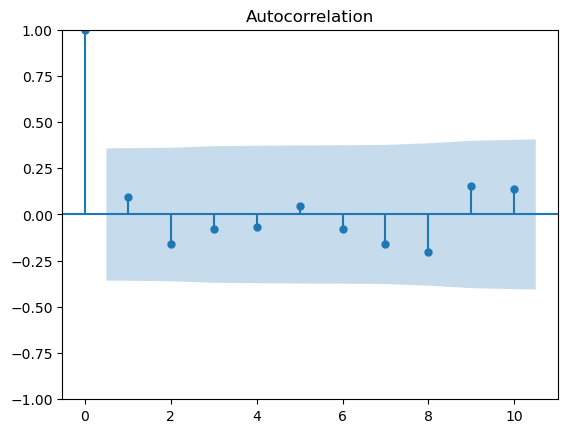

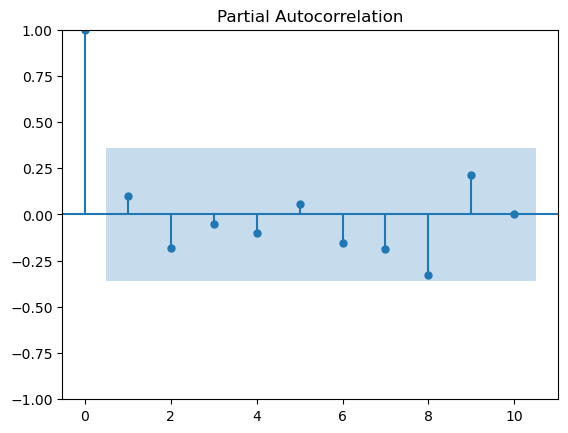

In [200]:
plot_acf(precio_log_diff,lags=10)
plt.show()

plot_pacf(precio_log_diff,lags=10)
plt.show()

#### Conclusión
No hay autocorrelacion entre los datos

### Modelo de Predicción

In [306]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [280]:
df_for_prediction = df_dollar_daily_price.copy()
df_for_prediction['precio_log'] = np.log(df_for_prediction['precio'])
df_for_prediction.drop('precio', axis=1, inplace=True)

In [298]:
test_percentage = math.ceil(len(df_for_prediction) * 0.7)
train_data = df_for_prediction[:test_percentage]['precio_log']
test_data = df_for_prediction[test_percentage:]['precio_log']

#### ARIMA

In [301]:
arima_model = ARIMA(train_data.values, order=(1,1,0))
arima_model_fit = arima_model.fit()

#predictions
predictions = arima_model_fit.forecast(len(test_data.values), alpha=0.05)
prediction_series = pd.Series(predictions, index=test_data.index)

error = mean_squared_error(test_data.values, predictions)
print('MSE:', error)

MSE: 0.0009378115874896169


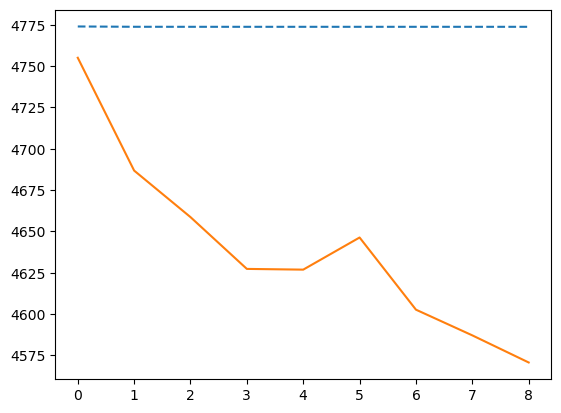

In [289]:
plt.plot(np.exp(predictions),'--',label='Predictions')
plt.plot(np.exp(test_data),label='True data')

#### Regresor con Arboles de Decisión

In [314]:
df_for_rf_regressor =  df_dollar_daily_price.copy()
df_for_rf_regressor.drop(columns=['fecha'], axis=1, inplace=True)
df_for_rf_regressor['precio_ayer'] = df_for_rf_regressor['precio'].shift(1)
df_for_rf_regressor.dropna(inplace=True)

In [315]:
train_size = math.ceil(len(df_for_rf_regressor) * 0.7)
train_data = df_for_rf_regressor[:train_size]
test_data = df_for_rf_regressor[train_size:]

In [316]:
train_data.dtypes

precio         float64
precio_ayer    float64
dtype: object

In [317]:
regressor = DecisionTreeRegressor()

regressor.fit(train_data.drop('precio', axis=1), train_data['precio'])

DecisionTreeRegressor()

In [319]:
predictions = regressor.predict(test_data.drop('precio', axis=1))
predictions

array([4734.7354, 4748.1538, 4744.5885, 4744.5885, 4744.5885, 4744.5885,
       4744.5885, 4744.5885, 4744.5885])